<a href="https://colab.research.google.com/github/alexander-n-thomas/spark-nlp-book-prod/blob/master/2_5_Processing_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.1

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 61kB/s 
     |████████████████████████████████| 204kB 35.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130388 sha256=74f114b3e295a0ad1caf8a24e3e0478ffc9d930556eb05b8f5bf35905c155cbb
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
     |████████████████████████████████| 122kB 2.8MB/s 


In [2]:
! mkdir -p data

In [3]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz

--2020-07-23 14:34:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1860687 (1.8M) [application/x-httpd-php]
Saving to: ‘mini_newsgroups.tar.gz’

mini_newsgroups.tar 100%[===================>]   1.77M  1.96MB/s    in 0.9s    

2020-07-23 14:34:22 (1.96 MB/s) - ‘mini_newsgroups.tar.gz’ saved [1860687/1860687]



In [31]:
! tar xzf mini_newsgroups.tar.gz -C ./data/

# Part 2: Building Blocks

In this part of the book, we will introduce the techniques you’ll need for building
your own NLP application. Understanding how and why these techniques work will
equip you with the tools needed to apply and adapt techniques you learn here and
elsewhere to your own application.

First, we will start off with the fundamental text processing tasks.

# Processing Words

This chapter focuses on the basic word-processing techniques you can apply to get started with NLP, including tokenization, vocabulary reduction, bag-of-words, and N-grams. You can solve many tasks with these techniques plus some basic machine learning. Knowing how, when, and why to use these techniques will help you with simple and complicated NLP tasks. This is why the discussion of the linguistics technique covers implementation. We will focus on working with English for now, though we will mention some things that should be considered when working with other languages. We are focusing on English because it would be very difficult to cover these techniques in depth across different languages.

Let's load the data from the mini_newsgroups again, and then we will explore tokenization.

In [4]:
import os

from pyspark.sql.types import *
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher

spark = sparknlp.start()

In [32]:
space_path = os.path.join('data', 'mini_newsgroups', 'sci.space')
texts = spark.sparkContext.wholeTextFiles(space_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema).persist()

In [6]:
## excerpt from mini newsgroups modified for examples
example = '''
Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.
'''

example = spark.createDataFrame([('.', example)], schema=schema).persist()

## Tokenization

Language data, from both text and speech, is sequential data. When working with sequential data, it is vital to understand what your sequences are made up of. On disk and in memory, our text data is a sequence of bytes. We use encodings like UTF-8 to turn these bytes into characters. This is the first step toward interpreting our data as language. This is almost always straightforward because we have agreed-upon standards for encoding characters as bytes. Turning bytes into characters is not enough to get the useful information we want, however. We next need to turn our sequence of characters into words. This is called tokenization.

Although we all intuitively understand what a "word" is, defining it linguistically is more difficult. Identifying a word is easy for a human. Let's look at some examples:

"monasticism"
"globglobism"
"xhbkgerj"
"-ism"
English speakers will recognize example 1 as a word, example 2 as a possible word, and example 3 as not a possible word; example 4 is trickier. The suffix "-ism" is something we attach to a word, a bound morpheme, but it has been used as an unbound morpheme. Indeed, there are languages that do not traditionally have word boundaries in their writing, like Chinese. So, although we can recognize what is and is not a word when standing alone, it is more difficult to define what is and is not a word in a sequence of words. We can go with the following definition: a sequence of morphemes is a word if splitting it apart or combining it with neighboring morphemes would change the meaning of the sentence.

In English, and other languages that use a delimiter between words, it is common to use regular expressions to tokenize. Let's look at some examples.

 First, let's look at a whitespace tokenizer:

In [7]:
from pyspark.ml.feature import RegexTokenizer

ws_tokenizer = RegexTokenizer()\
    .setInputCol('text')\
    .setOutputCol('ws_tokens')\
    .setPattern('\\s+')\
    .setGaps(True)\
    .setToLowercase(False)

text, tokens = ws_tokenizer.transform(example)\
    .select("text", "ws_tokens").first()

In [8]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



This leaves a lot to be desired. We can see that we have many tokens that are words with some punctuation attached. Let's add the boundary pattern "\b."

In [9]:
b_tokenizer = RegexTokenizer()\
    .setInputCol('text')\
    .setOutputCol('b_tokens')\
    .setPattern('\\s+|\\b')\
    .setGaps(True)\
    .setToLowercase(False)

text, tokens = b_tokenizer.transform(example)\
    .select("text", "b_tokens").first()

In [10]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [11]:
print(tokens)

['Nick', "'", 's', 'right', 'about', 'this', '.', 'It', "'", 's', 'always', 'easier', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', 'Britan', "'", 's', 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'american', 'subjects', 'to', 'cross', 'the', 'alleghany', '/', 'appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', 'couldn', "'", 't', '.']


We have the punctuation separated, but now all the contractions are broken into three tokens—for example, "It's" becomes "It", "'", "s". This is less than ideal. 

In Spark NLP, the tokenizer is more sophisticated than just single regex. It takes the following parameters (apart from the usual input and output column name parameters):

* compositeTokens  
These are multitoken words that you may not want to split (e.g., "New York").
* targetPattern  
This is the basic pattern for defining candidate tokens.
* infixPatterns  
These are the patterns for separating tokens that are found inside candidate tokens.
* prefixPattern  
This is the pattern for separating tokens that are found at the beginning of candidate tokens.
* suffixPattern  
This is the pattern for separating tokens that are found at the end of candidate tokens.

The algorithm works in the following steps:

1. Protect the composite tokens.
2. Create the candidate tokens.
3. Separate out the prefix, infix, and suffix patterns.

Let's see an example.

In [12]:
from sparknlp.annotator import Tokenizer

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
finisher = Finisher()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCols(['tokens'])\
    .setOutputAsArray(True)
pipeline = Pipeline()\
    .setStages([assembler, tokenizer, finisher])

text, tokens = pipeline.fit(texts).transform(example)\
    .select("text", "tokens").first()

In [ ]:
print(text)

In [13]:
print(tokens)

["Nick's", 'right', 'about', 'this', '.', "It's", 'always', 'easier', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'american', 'subjects', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


Here we see that the punctuation is separated out, and the contractions are split into two tokens. This matches closely with the intuitive definition of the word.

Now that we have our tokens, we have another thing to contend with—reducing our vocabulary.

## Vocabulary Reduction

Most NLP tasks involve turning the text into vectors. Initially, your vectors will have dimension equal to your vocabulary. An implicit assumption to doing this is that the words are orthogonal to each other. In terms of words, this means that "cat," "dog," and "dogs" are all considered equally different. We would like to represent words in a vector space that is somehow related to their meaning, but that is more complicated. We will cover such representations in Chapters #topic_modeling and #word_embeddings. There are simpler ways to tackle this problem, however. If we know that two words are almost the same, or are at least equivalent for our purposes, we can represent them with the same dimension in our vector. This will help classification, regression, and search tasks. So how can we do this? We can use our knowledge of morphology (how words are constructed from smaller words and affixes). We can remove affixes before constructing our vector. The two primary techniques for doing this are stemming and lemmatization.

### Stemming

Stemming is the process of removing affixes and leaving a word stem. This is done according to sets of rules that determine what characters to delete or replace. The first  stemming algorithm was created by Julie Beth Lovins in 1968, although there had been earlier work done on the subject.   In 1980, Martin Porter created the Porter Stemmer. This is certainly the most well-known stemming algorithm. He later created a domain-specific language and associated tools for writing stemming algorithms called snowball. Although people almost always use a predefined stemmer, if you find that there are affixes that are not being removed but should be, or the other way around, consider writing or modifying an existing algorithm.

### Lemmatization

Lemmatization is the process of replacing a word with its   lemma or head-word. The lemma is the form of a word that has a full dictionary entry. For example, if you look up "oxen" in a dictionary, it will likely redirect you to "ox." Algorithmically, this is easy to implement but is dependent on the data you use for looking up lemmas.

### Stemming Versus Lemmatization

There are pros and cons to both stemming and lemmatization.

* Stemming has the pro of requiring almost no memory, unlike lemmatization, which requires a dictionary.
* Lemmatization is generally quicker, since it is just a hash map lookup.
* Stemming can be easily tuned because it is based on an algorithm instead of a data source.
* Lemmatization returns an actual word, which makes inspecting results easier.
Which method you use will depend on your task and your resource constraints.

Use stemming if:

* You need to tune how much you reduce your vocabulary.
* You have tight memory constraints and fewer time constraints.
* You expect many new or unknown words.

Use lemmatization if:

* You need results of processing exposed to users.
* You have tight time constraints and less restriction on memory.

Let's look at some examples of using stemming and lemmatization in Spark NLP.

In [14]:
from sparknlp.annotator import Stemmer, Lemmatizer, LemmatizerModel

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
stemmer = Stemmer()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('stems_annotations')
# The next line downloads lemmatizer "model". Here, "training" 
# is reading the user supplied dictionary
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('lemma_annotations')
finisher = Finisher()\
    .setInputCols(['stems_annotations', 'lemma_annotations'])\
    .setOutputCols(['stems', 'lemmas'])\
    .setOutputAsArray(True)

pipeline = Pipeline()\
    .setStages([
        assembler, tokenizer, stemmer, lemmatizer, finisher])
text, stems, lemmas = pipeline.fit(texts).transform(example)\
    .select("text", "stems", "lemmas").first()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [15]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [16]:
print(stems)

["nick'", 'right', 'about', 'thi', '.', "it'", 'alwai', 'easier', 'to', 'obtian', 'forgiv', 'than', 'permiss', '.', 'not', 'mani', 'poepl', 'rememb', 'that', "britan'", 'kng', 'georg', 'iii', 'expressli', 'forbad', 'hi', 'american', 'subject', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountain', '.', 'said', 'subject', 'basic', 'said', ',', '"', 'stop', 'u', 'if', 'you', 'can', '."', 'he', "couldn't", '.']


In [17]:
print(lemmas)

["Nick's", 'right', 'about', 'this', '.', "It's", 'always', 'easy', 'to', 'obtian', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'poeple', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbid', 'he', 'american', 'subject', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountain', '.', 'Said', 'subject', 'basically', 'say', ',', '"', 'Stop', 'we', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


Some examples to note:

* The word "forbade" is stemmed to "forbad" and lemmatized to "forbid."
* The contraction "n't" is not affected by stemming, but lemmatization converts it to "not."
* The word "forgiveness" is stemmed to "forgiv" and it is not affected by lemmatization.
* The word "Britain's" (a possessive) is stemmed to ["britain", "'"] and lemmatized to ["Britain", "have"] erroneously .

#### **Note for Non-English Languages**

The typology of the language will greatly influence which approach is easier. There are common forms of words that have drastically different meanings. For example, in Spanish we would not want to combine "puerto" ("port") and "puerta" ("door"), but we may want to combine "niño" ("boy") and "niña" ("girl"). This means that reductions will be dependent on the lexical semantics (meaning of the word). This would be near impossible to fully support in a stemming algorithm, so you likely want to lemmatize. On the other hand, if a language has a rich morphology, the lemma dictionary will be very large (the number of forms times the number of words)

### Spelling Correction

An often overlooked aspect of vocabulary reduction is misspellings. In text that is not edited or proofread by the author, this can create a very long tail. Worse, there are some mistakes that are so common that the misspelling can actually be a moderately common token, which makes it very hard to remove.

There are two approaches to spelling correction in Spark NLP.  SymmetricDelete needs a set of correct words to search. This vocabulary can be provided as a dictionary, or by providing a trusted corpus.  It is based on the SymSpell project by Wolf Garbe.  The other approach is the Norvig spelling correction algorithm, which works by creating a simple probability model. This approach also needs a correct vocabulary, but it suggests the most probable word—i.e., the most frequent word in the trusted corpus with a certain edit distance from the given word.

Let's look at the pretrained Norvig spelling correction.

In [18]:
from sparknlp.annotator import NorvigSweetingModel
from sparknlp.annotator import SymmetricDeleteModel

In [19]:
# Norvig pretrained
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
finisher = Finisher()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCols(['norvig'])\
    .setOutputAsArray(True)

pipeline = Pipeline()\
    .setStages([
    assembler, tokenizer, norvig_pretrained, lemmatizer, finisher])
text, norvig = pipeline.fit(texts).transform(example)\
    .select("text", "norvig").first()

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]


In [20]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [21]:
print(norvig)

['Nicks', 'right', 'about', 'this', '.', 'Itys', 'always', 'easier', 'to', 'obtain', 'forgiveness', 'than', 'permission', '.', 'Not', 'many', 'people', 'remember', 'that', "Britan's", 'Kng', 'George', 'III', 'expressly', 'forbade', 'his', 'americana', 'subjects', 'to', 'cross', 'the', 'alleghany/appalachian', 'mountains', '.', 'Said', 'subjects', 'basically', 'said', ',', '"', 'Stop', 'us', 'if', 'you', 'can', '."', 'He', "couldn't", '.']


We see that "obtian," "poeple," and "Britan" are all corrected. However, "Kng" is missed, and "american" is converted to "Americana." The latter two mistakes are likely due to capitalization, which makes matching with the probability model more difficult.

### Normalization

This is a more heuristic-based cleanup step. If you are processing data scraped from the web, it is not uncommon to have HTML artifacts (tags, HTML encodings, etc.) left behind. Getting rid of these artifacts can reduce your vocabulary by quite a bit. If your task does not require numbers or anything nonalphabetic, for instance, you can also use normalization to remove these.

In [22]:
from sparknlp.annotator import Normalizer

In [23]:
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCol('lemma_annotations')
normalizer = Normalizer()\
    .setInputCols(['lemma_annotations'])\
    .setOutputCol('normtoken_annotations')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normtoken_annotations'])\
    .setOutputCols(['normtokens'])\
    .setOutputAsArray(True)

sparknlp_pipeline = Pipeline().setStages([
    assembler, tokenizer, norvig_pretrained, 
    lemmatizer, normalizer, finisher
])

pipeline = Pipeline()\
    .setStages([
        assembler, tokenizer, norvig_pretrained, 
        lemmatizer, normalizer, finisher])
text, normalized = pipeline.fit(texts).transform(example)\
    .select("text", "normtokens").first()

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [24]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [25]:
print(normalized)

['nicks', 'right', 'about', 'this', 'itys', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']


## Bag-of-Words
  Now that we have reduced our vocabulary by combining similar and misspelled words and removing HTML artifacts, we can feel confident that the vocabulary we are working with is a realistic reflection of the content of our documents. The next step is to turn these words into vectors for our model. There are many techniques for doing this, but we will start with the most straightforward approach, called bag-of-words.   A bag (also called a multiset), is a set in which each element has a count. If you are familiar with the Python collection Counter, that is a good way to understand what a bag is. And so, a bag-of-words is the count of the words in our document. Once we have these counts, we turn them into a vector by mapping each unique word to an index.

Let's look at a simple example using Python's `Counter`.

In [26]:
text = "the cat in the hat"
tokens = text.split()
tokens

['the', 'cat', 'in', 'the', 'hat']

In [27]:
from collections import Counter

counts = Counter(tokens)
counts

Counter({'cat': 1, 'hat': 1, 'in': 1, 'the': 2})

In [28]:
index = {token: ix for ix, token in enumerate(counts.keys())}
index

{'cat': 1, 'hat': 3, 'in': 2, 'the': 0}

In [29]:
import numpy as np

vec = np.zeros(len(index))

for token, count in counts.items():
    vec[index[token]] = count
    
vec

array([2., 1., 1., 1.])

The example we have is for only one document. If we are working on a large corpus, our index will have far more words than we would expect to ever find in a single document. It is not uncommon for corpus vocabularies to number in the tens of thousands or hundreds of thousands, even though a single document will generally have tens to hundreds of unique words. For this reason, we want our vectors to be sparse.

A sparse vector is one in which only the nonzero values are stored. Sparse vectors are generally implemented as associative arrays, maps, or dictionaries from index to value. For sparse data, like bags-of-words, this can save a great deal of space. However, not all algorithms are implemented in a way that is compatible with sparse vectors.

In Spark, we can use the `CountVectorizer` to create our bags-of-words.

### CountVectorizer

In [33]:
from pyspark.ml.feature import CountVectorizer

assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')
tokenizer = Tokenizer()\
    .setInputCols(['doc'])\
    .setOutputCol('tokens_annotations')
norvig_pretrained = NorvigSweetingModel.pretrained()\
    .setInputCols(['tokens_annotations'])\
    .setOutputCol('norvig_annotations')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['norvig_annotations'])\
    .setOutputCol('lemma_annotations')
normalizer = Normalizer()\
    .setInputCols(['lemma_annotations'])\
    .setOutputCol('normtoken_annotations')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normtoken_annotations'])\
    .setOutputCols(['normtokens'])\
    .setOutputAsArray(True)

sparknlp_pipeline = Pipeline().setStages([
    assembler, tokenizer, norvig_pretrained, 
    lemmatizer, normalizer, finisher
])

count_vectorizer = CountVectorizer()\
    .setInputCol('normtokens')\
    .setOutputCol('bows')

pipeline = Pipeline().setStages([sparknlp_pipeline, count_vectorizer])
model = pipeline.fit(texts)
processed = model.transform(example)
text, normtokens, bow = processed\
    .select("text", "normtokens", 'bows').first()

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [34]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [35]:
print(normtokens)

['nicks', 'right', 'about', 'this', 'dts', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']


Let's look at the bag-of-words. This will be a sparse vector, so the elements are indices into the vocabulary and counts of occurrences. For example, 7: 3.0 means that the seventh word in our vocabulary occurs three times in this document.

In [37]:
print(bow)

(5442,[0,3,8,14,16,24,28,30,32,46,52,67,78,108,126,150,185,216,338,375,443,757,803,835,1101,1271,1694,2160,2267,2289,3214,3502,3658,3980,4013,4518,4689],[1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])


We can get the learned vocabulary from the `CountVectorizerModel`. This is the list of words. In the previous example, we said that the seventh word occurs three times in a document. Looking at this vocabulary, that means that "have" occurs three times.

In [38]:
count_vectorizer_model = model.stages[-1]

vocab = count_vectorizer_model.vocabulary
print(vocab[:20])

['the', 'be', 'of', 'to', 'and', 'a', 'in', 'for', 'that', 'on', 'have', 'it', 'i', 'from', 'you', 'space', 'this', 'they', 'as', 'by']


The drawback to doing this is that we lose the meaning communicated by the arrangement of the words—the syntax. To say that parsing the syntax of natural language is difficult is an understatement. Fortunately, we often don't need all the information encoded in the syntax.

## N-Gram

The main drawback to using bag-of-words is that we are making use of only the meanings encoded in individual words and document-wide context. Language encodes a great deal of meaning in local contexts as well. Syntax is hard to model, let alone parse. Fortunately, we can use N-grams to extract some of the context without needing to use a complicated syntax parser.

N-grams, also known as shingles, are subsequences of words of length n within a string of words. They allow us to extract information from small windows of context. This gives us a first approximation of the information we can gather from syntax because, although we are looking at local context, there is structural information explicitly extracted. In many applications, N-grams are enough to extract the information necessary.

For low values of n there are special names. For example, 1-grams are called unigrams, 2-grams are called bigrams, and 3-grams are called trigrams. For values higher than 3, they are usually referred to as "number" + grams, like 4-grams.

Let's look at some example N-grams.

In [39]:
text = "the quick brown fox jumped over the lazy dog"
tokens = ["the", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog"]
unigrams = [('the',), ('quick',), ('brown',), ('fox',), ('jumped',), ('over',), ('the',), ('lazy',), ('dog',)]
bigrams = [('the', 'quick'), ('quick', 'brown'), ('brown', 'fox'), ('fox', 'jumped'), ('jumped', 'over'), ('over', 'the'), ('the', 'lazy'), ('lazy', 'dog')]
trigrams = [('the', 'quick', 'brown'), ('quick', 'brown', 'fox'), ('brown', 'fox', 'jumped'), ('fox', 'jumped', 'over'), ('jumped', 'over', 'the'), ('over', 'the', 'lazy'), ('the', 'lazy', 'dog')]

We still need to determine our n. Generally, n is less than 4. Consider the largest size multiword phrase you think will be important to your application. This will generally depend on the length of your documents and how technical the language is expected to be. In hospital medical records or in long documents with highly technical language, 3, 4, or even 5-grams might be useful. For tweets or short documents with informal language, bigrams should suffice.

Let's look at some examples.

In [40]:
from pyspark.ml.feature import NGram

bigrams = NGram()\
    .setN(2)\
    .setInputCol("normtokens")\
    .setOutputCol("bigrams")
trigrams = NGram()\
    .setN(3)\
    .setInputCol("normtokens")\
    .setOutputCol("trigrams")

pipeline = Pipeline().setStages([sparknlp_pipeline, bigrams, trigrams])
model = pipeline.fit(texts)
processed = model.transform(example)
text, normtokens, bigrams, trigrams = processed\
    .select("text", "normtokens", 'bigrams', 'trigrams').first()

In [41]:
print(text)


Nick's right about this.  It's always easier to obtian forgiveness than
permission.  Not many poeple remember that Britan's Kng George III
expressly forbade his american subjects to cross the alleghany/appalachian
mountains.  Said subjects basically said, "Stop us if you can."  He
couldn't.



In [42]:
print(normtokens)

['nicks', 'right', 'about', 'this', 'its', 'always', 'easy', 'to', 'obtain', 'forgiveness', 'than', 'permission', 'not', 'many', 'people', 'remember', 'that', 'britans', 'kng', 'george', 'iii', 'expressly', 'forbid', 'he', 'americana', 'subject', 'to', 'cross', 'the', 'alleghanyappalachian', 'mountain', 'said', 'subject', 'basically', 'say', 'stop', 'we', 'if', 'you', 'can', 'he', 'couldnt']


In [43]:
print(bigrams)

['nicks right', 'right about', 'about this', 'this itys', 'itys always', 'always easy', 'easy to', 'to obtain', 'obtain forgiveness', 'forgiveness than', 'than permission', 'permission not', 'not many', 'many people', 'people remember', 'remember that', 'that britans', 'britans kng', 'kng george', 'george iii', 'iii expressly', 'expressly forbid', 'forbid he', 'he americana', 'americana subject', 'subject to', 'to cross', 'cross the', 'the alleghanyappalachian', 'alleghanyappalachian mountain', 'mountain said', 'said subject', 'subject basically', 'basically say', 'say stop', 'stop we', 'we if', 'if you', 'you can', 'can he', 'he couldnt']


In [44]:
print(trigrams)

['nicks right about', 'right about this', 'about this dts', 'this dts always', 'dts always easy', 'always easy to', 'easy to obtain', 'to obtain forgiveness', 'obtain forgiveness than', 'forgiveness than permission', 'than permission not', 'permission not many', 'not many people', 'many people remember', 'people remember that', 'remember that britans', 'that britans kng', 'britans kng george', 'kng george iii', 'george iii expressly', 'iii expressly forbid', 'expressly forbid he', 'forbid he americana', 'he americana subject', 'americana subject to', 'subject to cross', 'to cross the', 'cross the alleghanyappalachian', 'the alleghanyappalachian mountain', 'alleghanyappalachian mountain said', 'mountain said subject', 'said subject basically', 'subject basically say', 'basically say stop', 'say stop we', 'stop we if', 'we if you', 'if you can', 'you can he', 'can he couldnt']


## Visualizing: Word and Document Distributions

Now that we have learned how to extract tokens, we can look at how we can visualize a data set.    We will look at two visualizations: word frequencies and word clouds from the space and autos newsgroups. They represent the same information but in different ways.

In [45]:
from sparknlp.pretrained import PretrainedPipeline

space_path = os.path.join('data', 'mini_newsgroups', 'sci.space')
space = spark.sparkContext.wholeTextFiles(space_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

space = spark.createDataFrame(space, schema=schema).persist()

sparknlp_pipeline = PretrainedPipeline(
    'explain_document_ml', lang='en').model

normalizer = Normalizer()\
    .setInputCols(['lemmas'])\
    .setOutputCol('normalized')\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)

count_vectorizer = CountVectorizer()\
    .setInputCol('normalized')\
    .setOutputCol('bows')

pipeline = Pipeline().setStages([
    sparknlp_pipeline, normalizer, finisher, count_vectorizer])
model = pipeline.fit(space)
processed = model.transform(space)

explain_document_ml download started this may take some time.
Approx size to download 9.4 MB
[OK!]


In [46]:
vocabulary = model.stages[-1].vocabulary
word_counts = Counter()

for row in processed.toLocalIterator():
    for ix, count in zip(row['bows'].indices, row['bows'].values):
        word_counts[vocabulary[ix]] += count

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

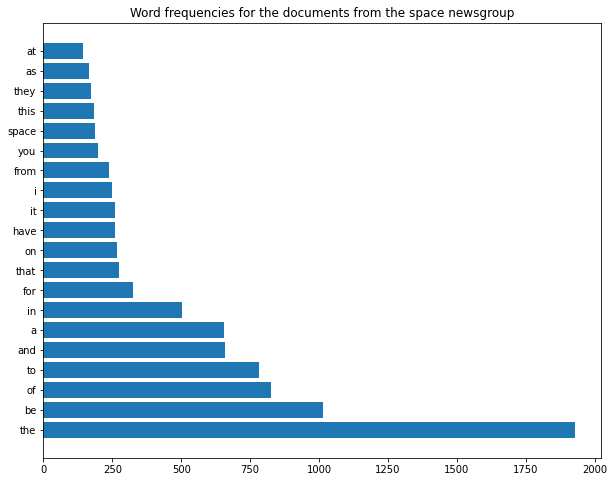

In [49]:
y = list(range(20))
top_words, counts = zip(*word_counts.most_common(20))

plt.figure(figsize=(10, 8))
plt.barh(y, counts)
plt.yticks(y, top_words)
plt.title('Word frequencies for the documents from the space newsgroup')
plt.show()

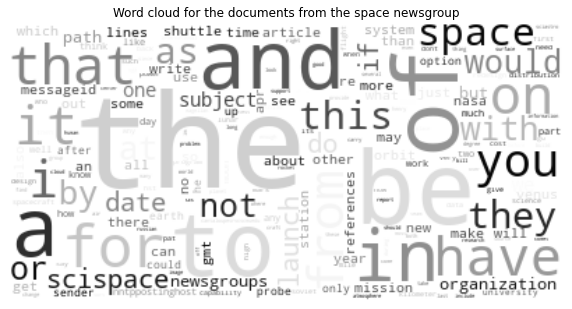

In [51]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 8))
wc = WordCloud(colormap='Greys', background_color='white')
im = wc.generate_from_frequencies(word_counts)
plt.imshow(im, interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud for the documents from the space newsgroup')

plt.show()

In [52]:
autos_path = os.path.join('data', 'mini_newsgroups', 'rec.autos')
autos = spark.sparkContext.wholeTextFiles(autos_path)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

autos = spark.createDataFrame(autos, schema=schema).persist()

model = pipeline.fit(autos)
processed = model.transform(autos)

In [53]:
vocabulary = model.stages[-1].vocabulary
word_counts = Counter()

for row in processed.toLocalIterator():
    for ix, count in zip(row['bows'].indices, row['bows'].values):
        word_counts[vocabulary[ix]] += count

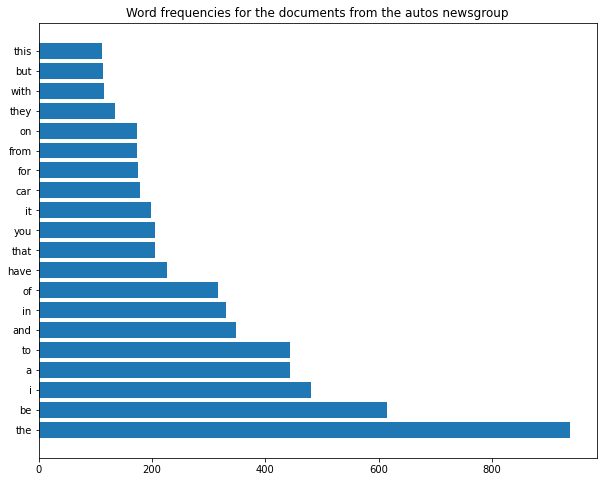

In [54]:
y = list(range(20))
top_words, counts = zip(*word_counts.most_common(20))

plt.figure(figsize=(10, 8))
plt.barh(y, counts)
plt.yticks(y, top_words)
plt.title('Word frequencies for the documents from the autos newsgroup')
plt.show()

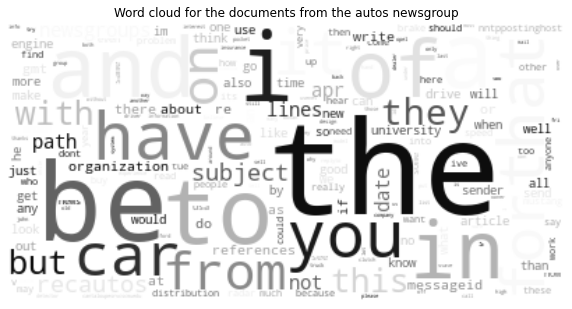

In [55]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 8))
wc = WordCloud(colormap='Greys', background_color='white')
im = wc.generate_from_frequencies(word_counts)
plt.imshow(im, interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud for the documents from the autos newsgroup')

plt.show()

Now we can visualize our text. However, they have such similar words. In the next chapter, we will learn how to address this issue.

## Exercises

We've visualized unigrams, but we have a problem with common words. Let's try visualizing N-grams. Try bigrams and trigrams.

## Resources

* Google Ngram Viewer: Google offers a way to look at the occurrence of N-grams in books through history.
* Hunspell: Hunspell is a very broadly used library for spell-checking and morphological analysis. 